# Basic Image Classification with Feedforward NN and LetNet5

All libraries we introduced in the last chapter provide support for convolutional layers. We are going to illustrate the LeNet5 architecture using the most basic MNIST handwritten digit dataset, and then use AlexNet on CIFAR10, a simplified version of the original ImageNet to demonstrate the use of data augmentation.
LeNet5 and MNIST using Keras.

## Imports

In [1]:
%matplotlib inline
from random import randint
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.datasets import mnist
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Dense, Dropout, Flatten
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
sns.set_style('whitegrid')

## Load MNIST Database

The original MNIST dataset contains 60,000 images in 28x28 pixel resolution with a single grayscale containing handwritten digits from 0 to 9. A good alternative is the more challenging but structurally similar Fashion MNIST dataset that we encountered in Chapter 12 on Unsupervised Learning.

We can load it in keras out of the box:

In [3]:
# use Keras to import pre-shuffled MNIST database
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("The MNIST database has a training set of %d examples." % len(X_train))
print("The MNIST database has a test set of %d examples." % len(X_test))

The MNIST database has a training set of 60000 examples.
The MNIST database has a test set of 10000 examples.


In [4]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

## Visualize Data

### Visualize First 10 Training Images

The below figure shows the first ten images in the dataset and highlights significant variation among instances of the same digit. On the right, it shows how the pixel values for an indivual image range from 0 to 255.

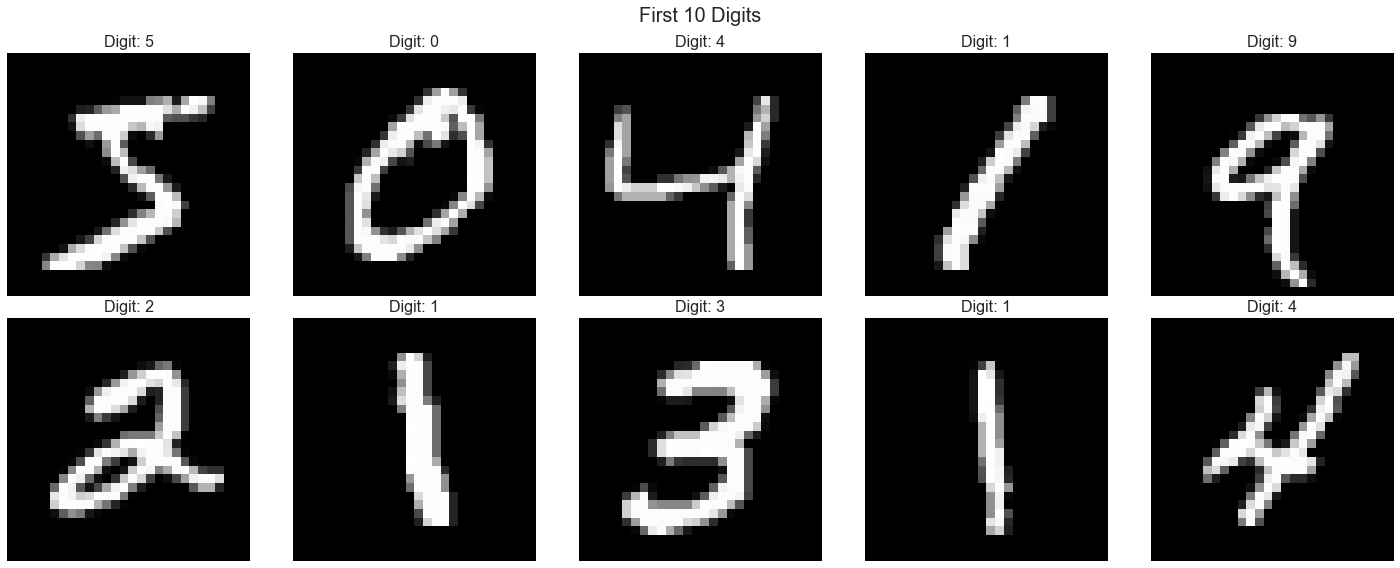

In [5]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(20, 8))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(X_train[i], cmap='gray')
    ax.axis('off')
    ax.set_title('Digit: {}'.format(y_train[i]), fontsize=16)
fig.suptitle('First 10 Digits', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.9)

### Show random image in detail

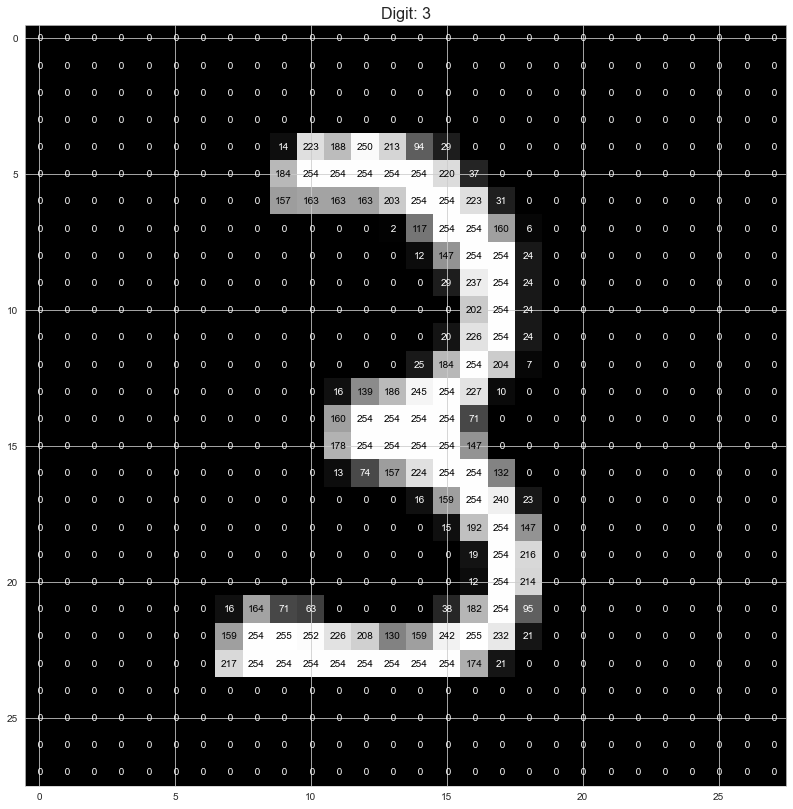

In [6]:
fig, ax = plt.subplots(figsize = (14, 14)) 

i = randint(0, len(X_train))
img = X_train[i]

ax.imshow(img, cmap='gray')
ax.set_title('Digit: {}'.format(y_train[i]), fontsize=16)

width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        ax.annotate('{:2}'.format(img[x][y]), 
                    xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

## Prepare Data

### Rescale pixel values

We rescale the pixel values to the range [0, 1] to normalize the training data and faciliate the backpropagation process and convert the data to 32 bit floats that reduce memory requirements and computational cost while providing sufficient precision for our use case:

In [7]:
# rescale [0,255] --> [0,1]
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255 

### One-Hot Label Encoding using Keras

Print first ten labels

In [8]:
print('Integer-valued labels:')
print(y_train[:10])

Integer-valued labels:
[5 0 4 1 9 2 1 3 1 4]


## Feed-Forward NN

### Model Architecture

In [47]:
ffnn = Sequential([
    Flatten(input_shape=X_train.shape[1:]),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='softmax')
])

In [48]:
ffnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
________________________________________________

### Compile the Model

In [49]:
ffnn.compile(loss='sparse_categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])

### Calculate Baseline Classification Accuracy

In [50]:
# evaluate test accuracy
baseline_accuracy = ffnn.evaluate(X_test, y_test, verbose=0)[1]

# print test accuracy
print(f'Test accuracy: {baseline_accuracy:.2%}')

Test accuracy: 11.46%


### Callback for model persistence

In [51]:
mnist_path = 'models/mnist.ffn.best.hdf5'

In [52]:
checkpointer = ModelCheckpoint(filepath=mnist_path, 
                               verbose=1, 
                               save_best_only=True)

### Early Stopping Callback

In [53]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

### Train the Model

In [54]:
epochs = 100
batch_size = 32

In [55]:
ffnn_history = ffnn.fit(X_train,
                        y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_split=0.2,
                        callbacks=[checkpointer, early_stopping],
                        verbose=1,
                        shuffle=True)

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
47328/48000 [============================>.] - ETA: 0s - loss: 0.2409 - accuracy: 0.9274
Epoch 00001: val_loss improved from inf to 0.13248, saving model to models/mnist.ffn.best.hdf5
48000/48000 [==============================] - 2s 50us/sample - loss: 0.2393 - accuracy: 0.9279 - val_loss: 0.1325 - val_accuracy: 0.9641
Epoch 2/100
47968/48000 [============================>.] - ETA: 0s - loss: 0.1285 - accuracy: 0.9665
Epoch 00002: val_loss improved from 0.13248 to 0.13076, saving model to models/mnist.ffn.best.hdf5
48000/48000 [==============================] - 2s 48us/sample - loss: 0.1284 - accuracy: 0.9665 - val_loss: 0.1308 - val_accuracy: 0.9683
Epoch 3/100
46912/48000 [============================>.] - ETA: 0s - loss: 0.1151 - accuracy: 0.9731
Epoch 00003: val_loss did not improve from 0.13076
48000/48000 [==============================] - 2s 48us/sample - loss: 0.1154 - accuracy: 0.9731 - val_loss: 0.1357 - val_accur

### Plot CV Results

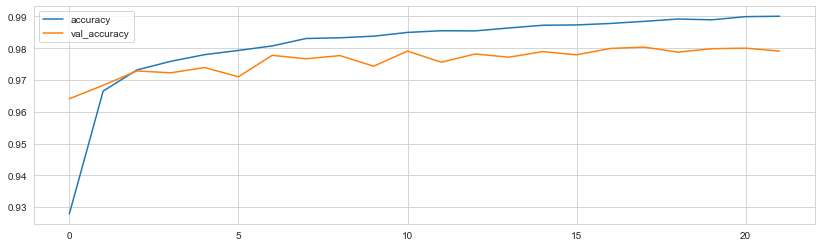

In [56]:
pd.DataFrame(ffnn_history.history)[['accuracy', 'val_accuracy']].plot(figsize=(14,4));

### Load the Best Model

In [57]:
# load the weights that yielded the best validation accuracy
ffnn.load_weights(mnist_path)

### Test Classification Accuracy

In [58]:
# evaluate test accuracy
ffnn_accuracy = ffnn.evaluate(X_test, y_test, verbose=0)[1]

print(f'Test accuracy: {ffnn_accuracy:.2%}')

Test accuracy: 97.05%


## LeNet5

In [23]:
K.clear_session()

### Model Architecture

We can define a simplified version of LeNet5 that omits the original final layer containing radial basis functions as follows, using the default ‘valid’ padding and single step strides unless defined otherwise:

In [24]:
lenet5 = Sequential([
    Conv2D(filters=6,
           kernel_size=5,
           activation='relu',
           input_shape=(28, 28, 1),
           name='CONV1'),
    AveragePooling2D(pool_size=(2, 2),
                     strides=(1, 1),
                     padding='valid',
                     name='POOL1'),
    Conv2D(filters=16, kernel_size=(5, 5), activation='tanh', name='CONV2'),
    AveragePooling2D(pool_size=(2, 2), strides=(2, 2), name='POOL2'),
    Conv2D(filters=120, kernel_size=(5, 5), activation='tanh', name='CONV3'),
    Flatten(name='FLAT'),
    Dense(units=84, activation='tanh', name='FC6'),
    Dense(units=10, activation='softmax', name='FC7')
])

The summary indicates that the model thus defined has over 300,000 parameters:

In [25]:
lenet5.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CONV1 (Conv2D)               (None, 24, 24, 6)         156       
_________________________________________________________________
POOL1 (AveragePooling2D)     (None, 23, 23, 6)         0         
_________________________________________________________________
CONV2 (Conv2D)               (None, 19, 19, 16)        2416      
_________________________________________________________________
POOL2 (AveragePooling2D)     (None, 9, 9, 16)          0         
_________________________________________________________________
CONV3 (Conv2D)               (None, 5, 5, 120)         48120     
_________________________________________________________________
FLAT (Flatten)               (None, 3000)              0         
_________________________________________________________________
FC6 (Dense)                  (None, 84)                2

We compile using crossentropy loss and the original stochastic gradient optimizer:

In [26]:
lenet5.compile(loss='sparse_categorical_crossentropy',
               optimizer='SGD',
               metrics=['accuracy'])

### Define checkpoint callback

In [27]:
lenet_path = 'models/mnist.lenet.best.hdf5'

In [28]:
checkpointer = ModelCheckpoint(filepath=lenet_path,
                               verbose=1,
                               save_best_only=True)

Now we are ready to train the model. The model expects 4D input so we reshape accordingly. We use the standard batch size of 32, 80-20 train-validation split, use checkpointing to store the model weights if the validation error improves, and make sure the dataset is randomly shuffled:

### Train Model

In [29]:
batch_size=32
epochs=100

In [30]:
lenet_history = lenet5.fit(
    X_train.reshape(-1, 28, 28, 1),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,  # use 0 to train on all data
    callbacks=[checkpointer, early_stopping],
    verbose=1,
    shuffle=True)

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
47680/48000 [============================>.] - ETA: 0s - loss: 0.4724 - accuracy: 0.8687
Epoch 00001: val_loss improved from inf to 0.24929, saving model to models/mnist.lenet.best.hdf5
48000/48000 [==============================] - 4s 75us/sample - loss: 0.4713 - accuracy: 0.8690 - val_loss: 0.2493 - val_accuracy: 0.9272
Epoch 2/100
47904/48000 [============================>.] - ETA: 0s - loss: 0.2075 - accuracy: 0.9409
Epoch 00002: val_loss improved from 0.24929 to 0.16762, saving model to models/mnist.lenet.best.hdf5
48000/48000 [==============================] - 3s 55us/sample - loss: 0.2075 - accuracy: 0.9409 - val_loss: 0.1676 - val_accuracy: 0.9525
Epoch 3/100
47904/48000 [============================>.] - ETA: 0s - loss: 0.1465 - accuracy: 0.9579
Epoch 00003: val_loss improved from 0.16762 to 0.12071, saving model to models/mnist.lenet.best.hdf5
48000/48000 [==============================] - 3s 56us/sample - loss: 0.

Epoch 26/100
47104/48000 [============================>.] - ETA: 0s - loss: 0.0181 - accuracy: 0.9954
Epoch 00026: val_loss improved from 0.04292 to 0.04217, saving model to models/mnist.lenet.best.hdf5
48000/48000 [==============================] - 3s 54us/sample - loss: 0.0182 - accuracy: 0.9953 - val_loss: 0.0422 - val_accuracy: 0.9883
Epoch 27/100
47424/48000 [============================>.] - ETA: 0s - loss: 0.0174 - accuracy: 0.9958
Epoch 00027: val_loss improved from 0.04217 to 0.04011, saving model to models/mnist.lenet.best.hdf5
48000/48000 [==============================] - 3s 58us/sample - loss: 0.0174 - accuracy: 0.9959 - val_loss: 0.0401 - val_accuracy: 0.9886
Epoch 28/100
47136/48000 [============================>.] - ETA: 0s - loss: 0.0165 - accuracy: 0.9959
Epoch 00028: val_loss did not improve from 0.04011
48000/48000 [==============================] - 3s 56us/sample - loss: 0.0164 - accuracy: 0.9959 - val_loss: 0.0437 - val_accuracy: 0.9866
Epoch 29/100
47776/48000 [=

Epoch 53/100
47008/48000 [============================>.] - ETA: 0s - loss: 0.0059 - accuracy: 0.9994
Epoch 00053: val_loss improved from 0.03687 to 0.03670, saving model to models/mnist.lenet.best.hdf5
48000/48000 [==============================] - 3s 56us/sample - loss: 0.0059 - accuracy: 0.9994 - val_loss: 0.0367 - val_accuracy: 0.9899
Epoch 54/100
47136/48000 [============================>.] - ETA: 0s - loss: 0.0057 - accuracy: 0.9994
Epoch 00054: val_loss did not improve from 0.03670
48000/48000 [==============================] - 3s 55us/sample - loss: 0.0057 - accuracy: 0.9994 - val_loss: 0.0375 - val_accuracy: 0.9891
Epoch 55/100
47872/48000 [============================>.] - ETA: 0s - loss: 0.0055 - accuracy: 0.9994
Epoch 00055: val_loss did not improve from 0.03670
48000/48000 [==============================] - 3s 55us/sample - loss: 0.0055 - accuracy: 0.9994 - val_loss: 0.0374 - val_accuracy: 0.9897
Epoch 56/100
47808/48000 [============================>.] - ETA: 0s - loss: 0

Epoch 81/100
47168/48000 [============================>.] - ETA: 0s - loss: 0.0027 - accuracy: 0.9998
Epoch 00081: val_loss improved from 0.03619 to 0.03615, saving model to models/mnist.lenet.best.hdf5
48000/48000 [==============================] - 3s 58us/sample - loss: 0.0027 - accuracy: 0.9998 - val_loss: 0.0362 - val_accuracy: 0.9907
Epoch 82/100
47712/48000 [============================>.] - ETA: 0s - loss: 0.0027 - accuracy: 0.9999
Epoch 00082: val_loss did not improve from 0.03615
48000/48000 [==============================] - 3s 57us/sample - loss: 0.0027 - accuracy: 0.9999 - val_loss: 0.0369 - val_accuracy: 0.9902
Epoch 83/100
47456/48000 [============================>.] - ETA: 0s - loss: 0.0026 - accuracy: 0.9999
Epoch 00083: val_loss did not improve from 0.03615
48000/48000 [==============================] - 3s 55us/sample - loss: 0.0026 - accuracy: 0.9999 - val_loss: 0.0368 - val_accuracy: 0.9898
Epoch 84/100
47360/48000 [============================>.] - ETA: 0s - loss: 0

### Plot CV Results

On a single GPU, 50 epochs take around 2.5 minutes, resulting in a test accuracy of 99.09%, slightly below the same result as for the original LeNet5:

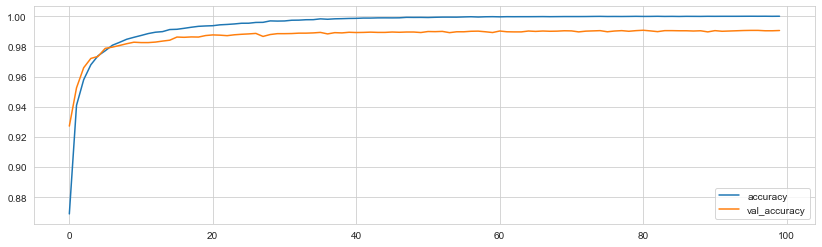

In [31]:
pd.DataFrame(lenet_history.history)[['accuracy', 'val_accuracy']].plot(figsize=(14,4));

### Test Classification Accuracy

In [32]:
# evaluate test accuracy
lenet_accuracy = lenet5.evaluate(X_test.reshape(-1, 28, 28, 1), y_test, verbose=0)[1]
print('Test accuracy: {:.2%}'.format(lenet_accuracy))

Test accuracy: 99.09%


## Summary

For comparison, a simple two-layer feedforward network achieves only 37.36% test accuracy. 

The LeNet5 improvement on MNIST is, in fact, modest. Non-neural methods have also achieved classification accuracies greater than or equal to 99%, including K-Nearest Neighbours or Support Vector Machines. CNNs really shine with more challenging datasets as we will see next.